<a href="https://colab.research.google.com/github/singhsukhendra/2015/blob/master/Baseline_CNN_on_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

In [5]:
import os
initial_count = 0
dir = "/content/drive/MyDrive/data/PNEUMONIA"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        initial_count += 1
print(initial_count)

4273


In [6]:
import os
initial_count = 0
dir = "/content/drive/MyDrive/data/NORMAL"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        initial_count += 1
print(initial_count)




1583


In [7]:
'''
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(str(e))
    return np.array(data)
  
data = get_training_data('drive/MyDrive/data/')
np.save('data.npy', data, allow_pickle=True)
'''

"\ndef get_training_data(data_dir):\n    data = [] \n    for label in labels: \n        path = os.path.join(data_dir, label)\n        class_num = labels.index(label)\n        for img in os.listdir(path):\n            try:\n                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)\n                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size\n                data.append([resized_arr, class_num])\n            except Exception as e:\n                print(str(e))\n    return np.array(data)\n  \ndata = get_training_data('drive/MyDrive/data/')\nnp.save('data.npy', data, allow_pickle=True)\n"

In [8]:
# If you've already ran the previous code block, run this one instead.
data = np.load('drive/MyDrive/data/data.npy', allow_pickle=True)

In [9]:
# Shuffle dataset
np.random.seed(1337)
np.random.shuffle(data)

In [10]:
train, val, test = np.split(data, [int(.75*len(data)), int(.80*len(data))])

In [11]:
len(train),len(val),len(test)

(4392, 292, 1172)

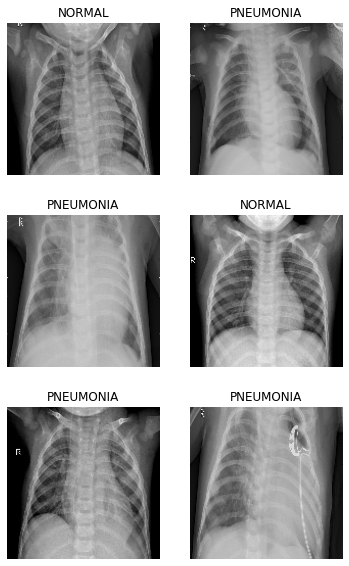

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(6,10), facecolor='white')
for idx, item in enumerate(np.random.randint(0, train.shape[0], 6)):
    ax[int(idx/2)][idx%2].imshow(train[item][0], cmap='gray')
    ax[int(idx/2)][idx%2].set_title(labels[train[item][1]])
    ax[int(idx/2)][idx%2].axis('off')

In [13]:
print(data.shape)
print(train.shape, val.shape, test.shape)

(5856, 2)
(4392, 2) (292, 2) (1172, 2)


In [14]:
# Train set splits
unique, counts = np.unique(train[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 3205]
 [1 1187]]


In [15]:
# Test set splits
unique, counts = np.unique(test[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 842]
 [1 330]]


In [16]:
# Validation set splits
unique, counts = np.unique(val[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 226]
 [1 66]]


In [17]:
unique, counts = np.unique(data[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 4273]
 [1 1583]]


In [18]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

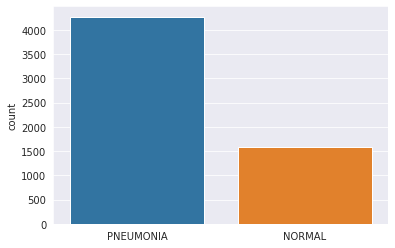

In [19]:
l = []
for i in data:
    if(i[1] == 0):
        l.append("PNEUMONIA")
    else:
        l.append("NORMAL")
sns.set_style('darkgrid')
sns.countplot(l)

In [20]:
# Normalize data. Pixels are [0, 255], so dividing will place them into a [0, 1] range.
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [21]:
# Resize all images into a common size of 150 x 150
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [22]:
print(x_train[0].shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(150, 150, 1) (4392, 150, 150, 1) (4392,) (292, 150, 150, 1) (292,) (1172, 150, 150, 1) (1172,)


In [23]:
# Data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [24]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
    model.add(BatchNormalization())
   
    
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    
    return model

In [25]:
n_epoch = 50
lr = 0.001
batchsz = 32


METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc', curve='ROC'), # roc curve
      tf.keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

In [26]:
optim = tf.keras.optimizers.Adam(lr=lr)
model = create_model()
model.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = METRICS)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=2, verbose=1, factor=0.8
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batchsz), 
    epochs = n_epoch, 
    validation_data = datagen.flow(x_val, y_val),
    callbacks = [learning_rate_reduction]
)

Epoch 1/50
138/138 [==============================] - 27s 112ms/step - loss: 0.2867 - tp: 931.0000 - fp: 281.0000 - tn: 2924.0000 - fn: 256.0000 - accuracy: 0.8777 - precision: 0.7682 - recall: 0.7843 - roc: 0.9350 - prc: 0.8257 - val_loss: 1.9981 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 226.0000 - val_fn: 66.0000 - val_accuracy: 0.7740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc: 0.5000 - val_prc: 0.2260 - lr: 0.0010
Epoch 2/50
138/138 [==============================] - 14s 99ms/step - loss: 0.2303 - tp: 983.0000 - fp: 202.0000 - tn: 3003.0000 - fn: 204.0000 - accuracy: 0.9076 - precision: 0.8295 - recall: 0.8281 - roc: 0.9578 - prc: 0.8926 - val_loss: 2.1397 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 226.0000 - val_fn: 66.0000 - val_accuracy: 0.7740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc: 0.5000 - val_prc: 0.2260 - lr: 0.0010
Epoch 3/50
138/138 [==============================] - ETA: 0s - loss: 0.2207 - tp: 998.0000 - fp:

In [27]:
results = model.evaluate(x_test,y_test)

37/37 [==============================] - 2s 34ms/step - loss: 0.1073 - tp: 314.0000 - fp: 30.0000 - tn: 812.0000 - fn: 16.0000 - accuracy: 0.9608 - precision: 0.9128 - recall: 0.9515 - roc: 0.9927 - prc: 0.9843


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [29]:
len(model.layers)

22

In [30]:
import pandas as pd



# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [31]:
print("Loss of the model is - " , results[0])
print("True positives of the model is - " , results[1])
print("False positives of the model is - " , results[2])
print("True negatives of the model is - " , results[3])
print("False negatives of the model is - " , results[4])
print("Accuracy of the model is - " , results[5]*100 , "%")
print("Precision of the model is - " , results[6])
print("Recall of the model is - " , results[7])
print("ROC_AUC of the model is - " , results[8])
print("PRC_AUC of the model is - " , results[9])

Loss of the model is -  0.10734228789806366
True positives of the model is -  314.0
False positives of the model is -  30.0
True negatives of the model is -  812.0
False negatives of the model is -  16.0
Accuracy of the model is -  96.07508778572083 %
Precision of the model is -  0.9127907156944275
Recall of the model is -  0.9515151381492615
ROC_AUC of the model is -  0.9926923513412476
PRC_AUC of the model is -  0.9843103885650635


In [32]:
def plot_metrics(history):
    
    fig = plt.gcf()
    fig.set_size_inches(20, 3 * 4)

    metrics = ['roc','accuracy','loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        lims = {'loss': {0,2}}
        name = metric.replace("_"," ").capitalize()
        sp = plt.subplot(2, 3, n + 1)
        plt.plot(history.epoch, history.history[metric], color='C0', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='C1', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric in lims:
            plt.ylim(lims[metric])

        plt.legend()

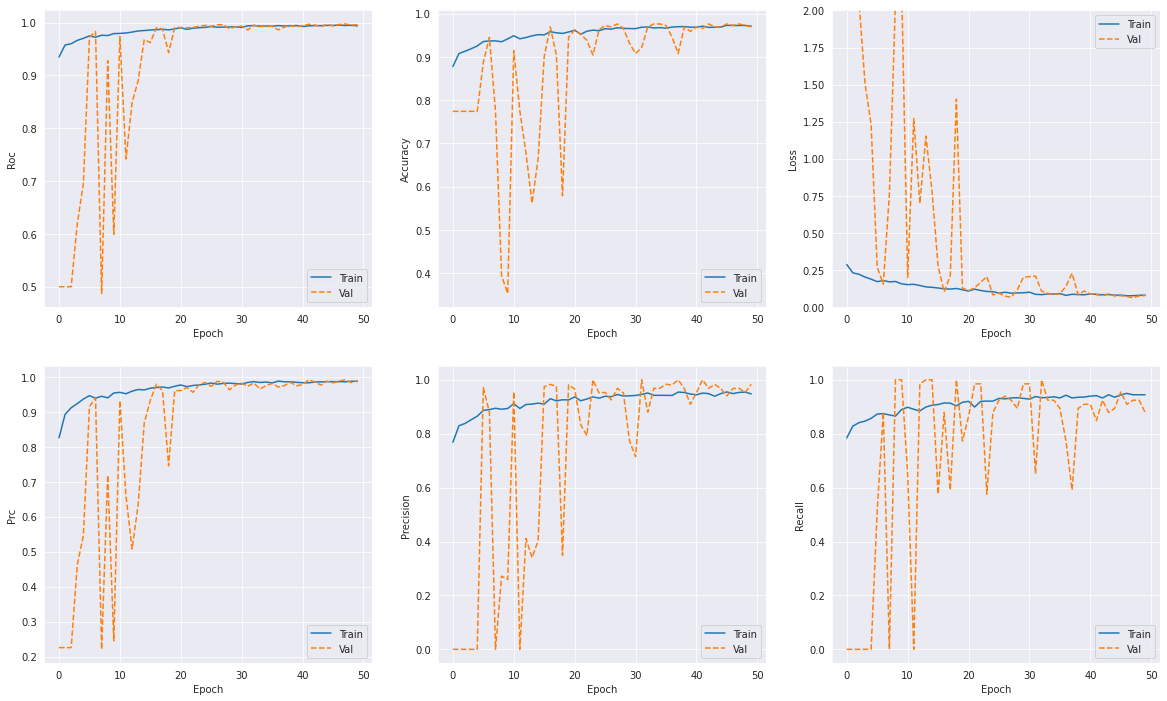

In [33]:
plot_metrics(history)

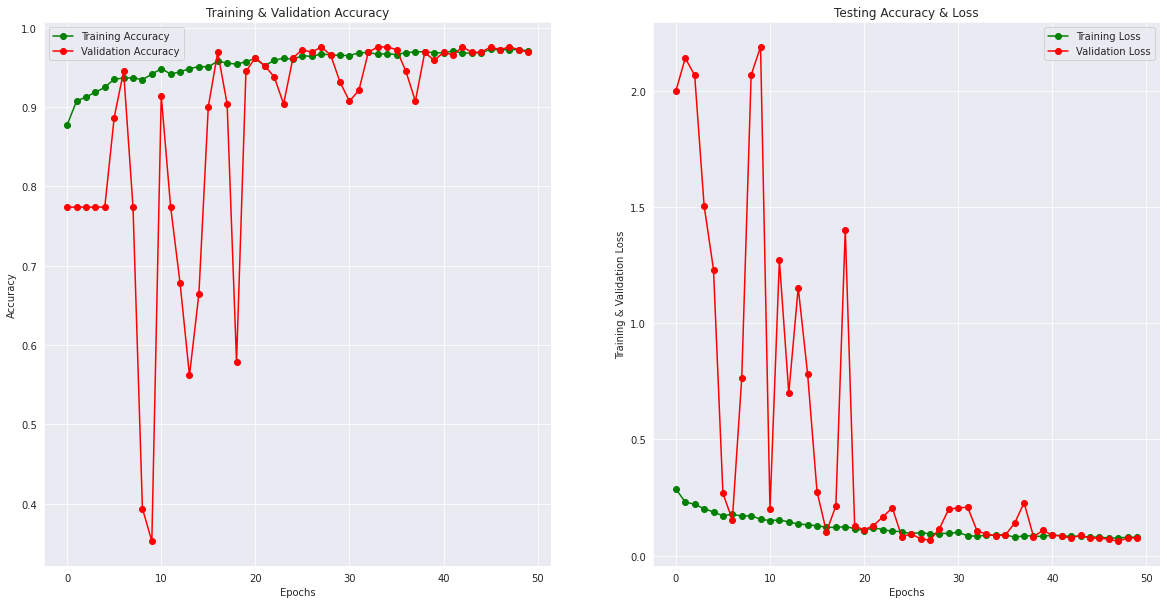

In [38]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [34]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.98      0.96      0.97       842
   Normal (Class 1)       0.91      0.95      0.93       330

           accuracy                           0.96      1172
          macro avg       0.95      0.96      0.95      1172
       weighted avg       0.96      0.96      0.96      1172



In [35]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions)

0.9317507418397627

Text(69.0, 0.5, 'true label')

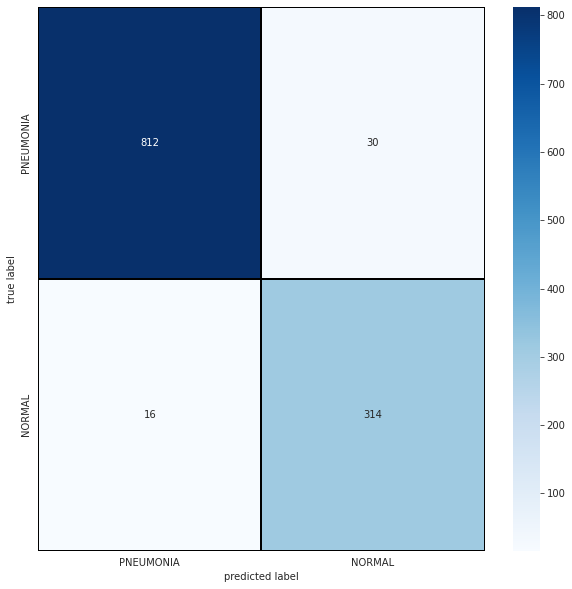

In [36]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.xlabel('predicted label')
plt.ylabel('true label')

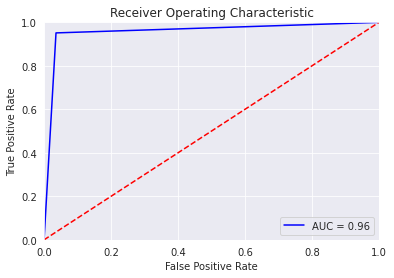

In [37]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = (model.predict(x_test) )
probs=predictions = (model.predict(x_test) > 0.5).astype("int32")
#predictions = predictions.reshape(1,-1)[0]
preds = probs[:,]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()